In [19]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.font_manager as pltfont
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from scipy import spatial
from scipy.cluster import hierarchy
from pyhpo import Ontology, HPOSet
from HPOFunctions import *
from clusteringFunctions import *
_ = Ontology()

# -------------------------------------------------------------------

### **Import pre-processed and filtered DECIPHER dataset**
- Remove patients with fewer than 4 associated HPO terms

In [20]:
# Read filtered DECIPHER data
decipher = pd.read_csv('./DataHandlingOutput/decipherFiltered.csv')

# Remove rows where the length of the list of HPO terms is less than 4.
decipherFiltered = decipher[decipher['HPOTermsFreq'] > 3]

# Find the number of patients remaining (399 patients)
num_rows = decipherFiltered.shape[0]
print(f'Patients with at least 4 HPO terms: {num_rows}')

Patients with at least 4 HPO terms: 399


### **Equalise HPO terms across patients**
- Remove redundant HPO terms
- Identify IQR and approximately equalise the number of HPO terms per patient up to the upper outlier value

In [21]:
# Identify outliers using the interquartile range for HPOList
decipherFiltered['HPOList'] = decipherFiltered['hpo_accessions'].str.split('|')
q1 = decipherFiltered['HPOList'].apply(len).quantile(0.25)
q3 = decipherFiltered['HPOList'].apply(len).quantile(0.75) 

# Calculate interquartile range and upper/lower outliers
iqr = q3 - q1
lowerOutlier = q1 - 1.5 * iqr
upperOutlier = q3 + 1.5 * iqr

# Remove HPO terms that are less relevant to clustering (such as modifier and obsolete terms) 
decipherFiltered = decipherFiltered.reset_index(drop=True)
decipherFiltered['HPOSet'] = decipherFiltered['HPOList'].apply(HPOSet.from_queries).apply(HPOSet.remove_modifier)
decipherFiltered['HPOSet'] = decipherFiltered['HPOSet'].apply(HPOSet.replace_obsolete)
decipherFiltered['HPOSet'] = decipherFiltered['HPOSet'].apply(HPOSet.child_nodes)
decipherFiltered['HPOList'] = decipherFiltered['HPOSet'].apply(get_HPO_list)

# Select patients that have a greater number of HPO terms than the upper outlier
decipher_upperOutliers = decipherFiltered[decipherFiltered['HPOList'].apply(len) > upperOutlier]

# Filter by retaining HPO terms with the highest IC (information content) up to the upper outlier number of HPO terms
decipher_upperOutliers['filteredHPOList'] = decipher_upperOutliers['HPOSet'].apply(filter_highest_ic_terms, max_number_of_terms=int(upperOutlier), list_or_object='list')
decipher_upperOutliers['filteredHPOSet'] = decipher_upperOutliers['filteredHPOList'].apply(HPOSet.from_queries)
merge = decipherFiltered.merge(decipher_upperOutliers, how='left', left_index=True, right_index=True)
decipherFiltered['filteredHPOList'] = merge['filteredHPOList'].fillna(merge['HPOList_x'])
decipherFiltered['filteredHPOSet'] = merge['filteredHPOSet'].fillna(merge['HPOSet_x'])
decipherFiltered = decipherFiltered.reset_index()

### **Compute the similarity between each patient-patient pair**
- Compute similarity between patients
- Create distance matrix and dendrogram

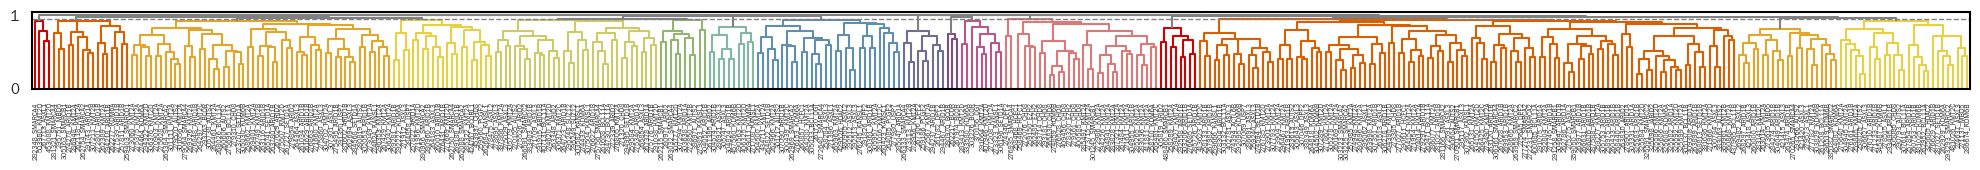

In [22]:
# Convert the pyhpo similarity function into a vectorized function
vsim = np.vectorize(HPOSet.similarity)

# Create two matrices that correspond with the pairs to compare in the next step
x, y = np.meshgrid(decipherFiltered['filteredHPOSet'], decipherFiltered['filteredHPOSet'])

# Semantic similarity is computed via the Graphic method, which checks for the sum of the IC of the common ancestors divided by the sum of the IC of the combined (union) parents of both terms (1 = identical terms) 
# The 'funSimAvg' method combines term-term similarity scores into set-set similarity scores
method, combine = 'graphic', 'funSimAvg'

# Run HPOSet.similarity on the whole of the two matrices
result = vsim(x, y, kind='omim', method=method, combine=combine)

# Create patient identifiers
decipherFiltered['patientID'] = (decipherFiltered["# patient_id"]).astype(str) + "_" +  (decipherFiltered["gene"]).astype(str) 
decipherFiltered.index = decipherFiltered['patientID']

# Set methods to use
affinity, linkageMethod = 'precomputed', 'complete'

# Convert result to pandas dataframe and add header and index.
graphicHPOsim = pd.DataFrame(result, index=decipherFiltered.index, columns=decipherFiltered.index)

# Convert the similarity matrix to a distance matrix: now 0 equals zero distance between terms, therefore identical terms = 0 -> This will be the input for the hierarchical cluster analysis.
graphicHPOdistance = pd.DataFrame(np.max(result)-(np.array(result)), index=decipherFiltered.index, columns=decipherFiltered.index)

# Convert distance matrix to distance vector.
distance1D = spatial.distance.squareform(np.max(result)-(np.array(result)), force='tovector', checks=False)

# Calculate hierarchical linkage from the distance vector.
linkage = hierarchy.linkage(distance1D, method = linkageMethod)

# Plot dendrogram without heatmap
palette = ['#d10000', '#db5e00','#e4a52b','#e7d044','#cdcb68','#93b572','#80b8a2','#5f8fb0','#6e6e92','#804d7e','#bc5589','#db7979']
customParams = {"axes.edgecolor": 'black', "axes.linewidth": 1.5}
plt.figure(figsize=(25, 1))
sns.set_theme(style= 'whitegrid', font_scale=1, font="Franklin Gothic Book", rc=customParams)
hierarchy.set_link_color_palette(palette)
hierarchy.dendrogram(linkage, labels=graphicHPOsim.index, color_threshold=0.95, above_threshold_color='grey', leaf_font_size=5)
plt.axhline(y=0.95, c='grey', lw=1, linestyle='dashed')
plt.xticks(rotation=90)
plt.grid()
plt.show()

### **Perform clustering**
- From the dendrogram it was decided that n=12 clusters, using a threshold of 0.95, was appropriate to try and identify specific phenotypic clusters
- Clusters labelled according to size

In [23]:
# Perform clustering
clustering = AgglomerativeClustering(n_clusters=12, affinity=affinity, linkage=linkageMethod).fit(graphicHPOdistance)

# Assign clusters to each patient
labels = clustering.labels_ + 1
decipherFiltered['cluster'] = labels

# Get filtered list length
decipherFiltered['filteredHPOListLength'] = decipherFiltered['filteredHPOList'].apply(len)

# Get counts for each cluster, and order by size
print(decipherFiltered.groupby(['cluster']).size().sort_values(ascending=False))

# Reassign clusters to each patient, from largest (1) to smallest (12)
labels = clustering.labels_ + 11
labels[labels == 15] = 1
labels[labels == 11] = 2
labels[labels == 12] = 3
labels[labels == 14] = 4
labels[labels == 21] = 5
labels[labels == 13] = 6
labels[labels == 20] = 7
labels[labels == 16] = 8
labels[labels == 17] = 9
labels[labels == 18] = 10
labels[labels == 19] = 11
labels[labels == 22] = 12
decipherFiltered['cluster'] = labels

cluster
5     111
1      91
2      48
4      44
11     32
3      30
10     10
6       9
7       9
8       8
9       4
12      3
dtype: int64


### **Checking for bias arising from imbalanced patient term freqeuncies**
- Several graphs were made to check that clusters are not largely driven by HPO term frequency
- While there is still a large range in the number of terms per patient, clustering does not appear to be driven by HPO frequency

<Figure size 640x480 with 0 Axes>

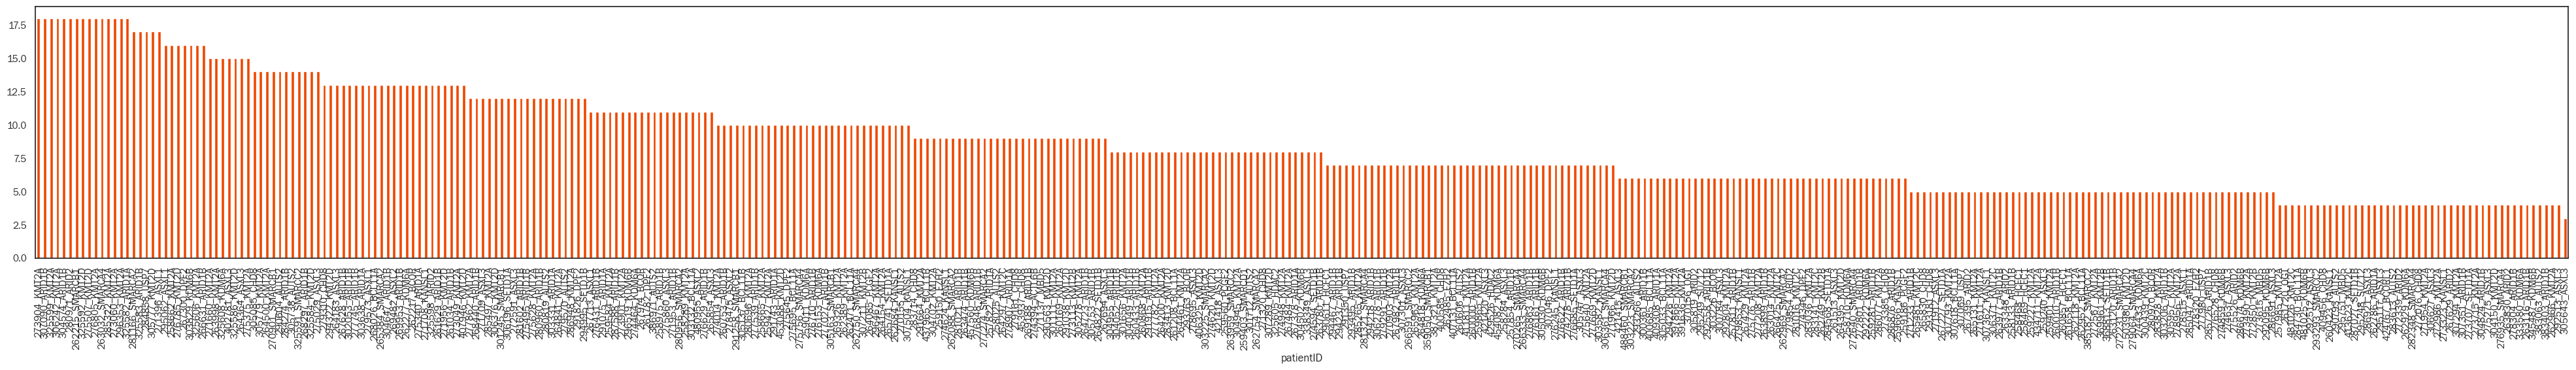

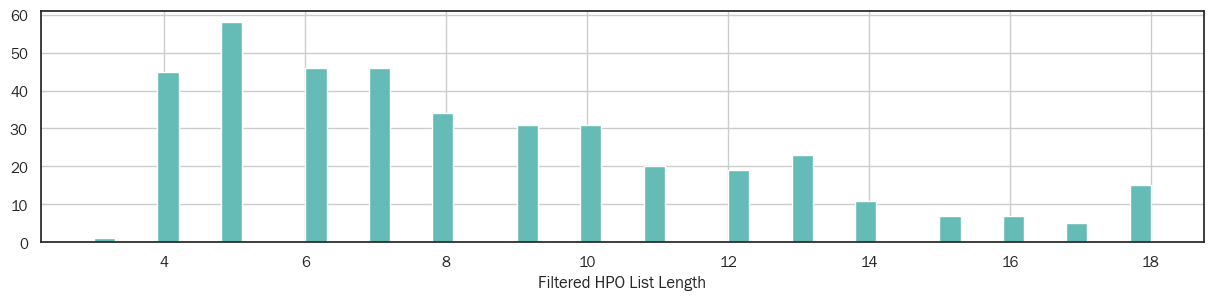

<Figure size 10000x300 with 0 Axes>

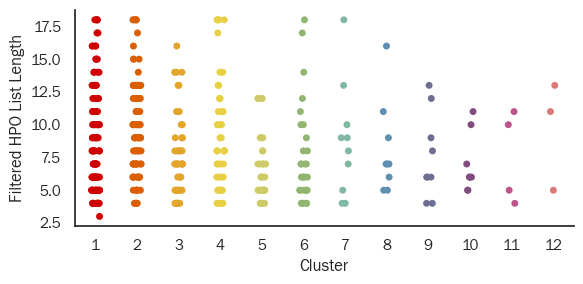

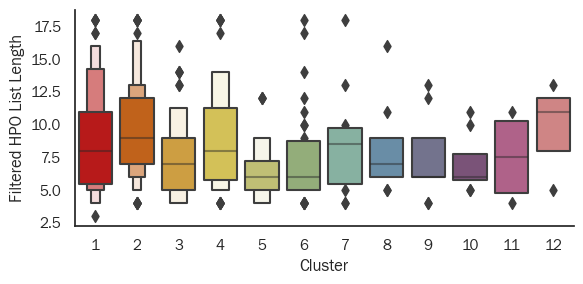

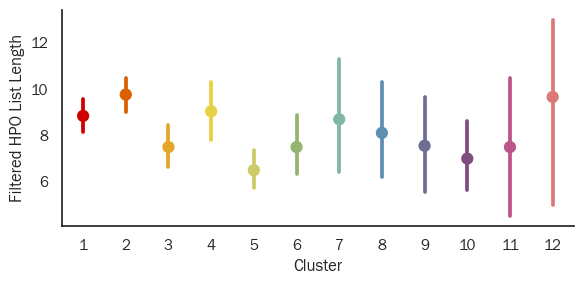

In [24]:
# Order decipher by filteredHPOListLength
decipherFiltered = decipherFiltered.sort_values(by='filteredHPOListLength', ascending=False)

# Plot a bar graph with the length of filteredHPOList per gene
plt.figure()
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#ee4800'])
decipherFiltered.plot.bar(x='patientID', y='filteredHPOListLength', rot=90, figsize=(50, 5), legend=False)

# Plot a histogram 
plt.figure(figsize=(15, 3))
sns.set_theme(style='white', font="Franklin Gothic Book",font_scale=1, palette=['#65bbb5'])
decipherFiltered['filteredHPOListLength'].hist(bins=50)
plt.xlabel('Filtered HPO List Length')

# Plot a categorical plots of filteredHPOListLength and the cluster number
plt.figure(figsize=(100, 3))
sns.set_theme(style='white', font="Franklin Gothic Book", font_scale=1)
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherFiltered, palette=palette, height=3, aspect=2)
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherFiltered, palette=palette, height=3, aspect=2, kind='boxen')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')
plt.savefig('./Figures/PatientClustersBox.png', dpi=500, bbox_inches="tight")
sns.catplot(x='cluster', y='filteredHPOListLength', data=decipherFiltered, palette=palette, height=3, aspect=2, kind='point')
plt.ylabel('Filtered HPO List Length')
plt.xlabel('Cluster')

# Group the df by cluster and count the number of patients in each cluster.
decipherClusterCount = decipherFiltered.groupby('cluster').count()

# -------------------------------------------------------------------

### **Group patients by cluster**
- Patients were separated into different cluster dataframes

In [25]:
# Save as csv
decipherFiltered[['gene', 'cluster']].to_csv('./ClusteringPatientsOutput/PatientClusterLabels.csv') 

# Split dataframe by cluster, starting with largest cluster
decipherCluster1 = decipherFiltered[decipherFiltered['cluster'] == 1] 
decipherCluster2 = decipherFiltered[decipherFiltered['cluster'] == 2]
decipherCluster3 = decipherFiltered[decipherFiltered['cluster'] == 3]
decipherCluster4 = decipherFiltered[decipherFiltered['cluster'] == 4]
decipherCluster5 = decipherFiltered[decipherFiltered['cluster'] == 5]
decipherCluster6 = decipherFiltered[decipherFiltered['cluster'] == 6]
decipherCluster7 = decipherFiltered[decipherFiltered['cluster'] == 7]
decipherCluster8 = decipherFiltered[decipherFiltered['cluster'] == 8]
decipherCluster9 = decipherFiltered[decipherFiltered['cluster'] == 9]
decipherCluster10 = decipherFiltered[decipherFiltered['cluster'] == 10]
decipherCluster11 = decipherFiltered[decipherFiltered['cluster'] == 11]
decipherCluster12 = decipherFiltered[decipherFiltered['cluster'] == 12]

# Get frequency of patients in each cluster
clusterFreqs = [(len(decipherCluster1)), (len(decipherCluster2)), (len(decipherCluster3)), 
                (len(decipherCluster4)), (len(decipherCluster5)), (len(decipherCluster6)),
                (len(decipherCluster7)), (len(decipherCluster8)), (len(decipherCluster9)), 
                (len(decipherCluster10)), (len(decipherCluster11)), (len(decipherCluster12))]

# Identify the HPO terms across all clusters
allHPOterms = set()
decipherFiltered['propagatedTerms'].str.split("|").apply(allHPOterms.update)
freqHPOterms = len(list(allHPOterms))

### **Phenotypic comparison across the 12 clusters**
- Get the frequency & percentage occurance of each HPO term in each cluster
- Identify which terms are significantly increased in each cluster when compared to all other clusters as a group

In [26]:
clusterFreq = pd.DataFrame({'hpo_term': list(get_HPOID_cluster_freq(decipherCluster1, allHPOterms).keys()), 
                              'cluster_1_freq': list(get_HPOID_cluster_freq(decipherCluster1, allHPOterms).values()), 
                              'cluster_2_freq': list(get_HPOID_cluster_freq(decipherCluster2, allHPOterms).values()), 
                              'cluster_3_freq': list(get_HPOID_cluster_freq(decipherCluster3, allHPOterms).values()),
                              'cluster_4_freq': list(get_HPOID_cluster_freq(decipherCluster4, allHPOterms).values()), 
                              'cluster_5_freq': list(get_HPOID_cluster_freq(decipherCluster5, allHPOterms).values()), 
                              'cluster_6_freq': list(get_HPOID_cluster_freq(decipherCluster6, allHPOterms).values()), 
                              'cluster_7_freq': list(get_HPOID_cluster_freq(decipherCluster7, allHPOterms).values()), 
                              'cluster_8_freq': list(get_HPOID_cluster_freq(decipherCluster8, allHPOterms).values()), 
                              'cluster_9_freq': list(get_HPOID_cluster_freq(decipherCluster9, allHPOterms).values()),
                              'cluster_10_freq': list(get_HPOID_cluster_freq(decipherCluster10, allHPOterms).values()), 
                              'cluster_11_freq': list(get_HPOID_cluster_freq(decipherCluster11, allHPOterms).values()), 
                              'cluster_12_freq': list(get_HPOID_cluster_freq(decipherCluster12, allHPOterms).values())})

# Calculate percentages
for i in range(1,13):
    clusterFreq["cluster_"+str(i)+"_percent"] = (clusterFreq["cluster_"+str(i)+"_freq"])/clusterFreqs[i-1]

# Get HPO Terms increased in each cluster
for i in range(1,13):
    get_sigincreased_HPOTerms_cluster(i, clusterFreq, clusterFreqs, total_clusters=12)

# -------------------------------------------------------------------

### **Visualise phenotypic differences across the 12 clusters**
- Filter dataframe to prepare data for visualisation

In [27]:
# Get HPO terms present in at least 10% of patients in at least one cluster
clusterFreqSubset = clusterFreq[(clusterFreq['cluster_1_percent']>0.1) | (clusterFreq['cluster_2_percent']>0.1)|(clusterFreq['cluster_3_percent']>0.1)| 
                                 (clusterFreq['cluster_4_percent']>0.1) | (clusterFreq['cluster_5_percent']>0.1)|(clusterFreq['cluster_6_percent']>0.1)| 
                                 (clusterFreq['cluster_7_percent']>0.1) | (clusterFreq['cluster_8_percent']>0.1)|(clusterFreq['cluster_9_percent']>0.1)| 
                                 (clusterFreq['cluster_10_percent']>0.1)| (clusterFreq['cluster_11_percent']>0.1)|(clusterFreq['cluster_12_percent']>0.1)]

# Get p-values in each cluster for each HPO term
clusterFreqPval = clusterFreqSubset[["hpo_term", "cluster_1_sig_indicate", "cluster_2_sig_indicate", "cluster_3_sig_indicate", "cluster_4_sig_indicate", 
                                      "cluster_5_sig_indicate", "cluster_6_sig_indicate", "cluster_7_sig_indicate", "cluster_8_sig_indicate", 
                                      "cluster_9_sig_indicate", "cluster_10_sig_indicate", "cluster_11_sig_indicate", "cluster_12_sig_indicate"]]

# Get percentage occurance in each cluster for each HPO term
clusterFreqPhenotypes = clusterFreqSubset[["hpo_term", "cluster_1_percent", "cluster_2_percent", "cluster_3_percent", "cluster_4_percent", 
                                            "cluster_5_percent", "cluster_6_percent", "cluster_7_percent", "cluster_8_percent", 
                                            "cluster_9_percent", "cluster_10_percent", "cluster_11_percent", "cluster_12_percent"]]

# Rename for visualisation
clusterFreqPhenotypes = clusterFreqPhenotypes.rename(columns={'cluster_1_percent':f'Cluster 1 (n={clusterFreqs[0]})', 'cluster_2_percent':f'Cluster 2 (n={clusterFreqs[1]})', 'cluster_3_percent':f'Cluster 3 (n={clusterFreqs[2]})', 
                                                              'cluster_4_percent':f'Cluster 4 (n={clusterFreqs[3]})', 'cluster_5_percent':f'Cluster 5 (n={clusterFreqs[4]})', 'cluster_6_percent':f'Cluster 6 (n={clusterFreqs[5]})', 
                                                              'cluster_7_percent':f'Cluster 7 (n={clusterFreqs[6]})', 'cluster_8_percent':f'Cluster 8 (n={clusterFreqs[7]})', 'cluster_9_percent':f'Cluster 9 (n={clusterFreqs[8]})', 
                                                              'cluster_10_percent':f'Cluster 10 (n={clusterFreqs[9]})', 'cluster_11_percent':f'Cluster 11 (n={clusterFreqs[10]})', 'cluster_12_percent':f'Cluster 12 (n={clusterFreqs[11]})'})

# Reset indices
clusterFreqPhenotypes = clusterFreqPhenotypes.set_index("hpo_term")
clusterFreqPval = clusterFreqPval.set_index("hpo_term")

- Visualise the prevelance of the 5 identified top-level HPO terms across the 12 clusters

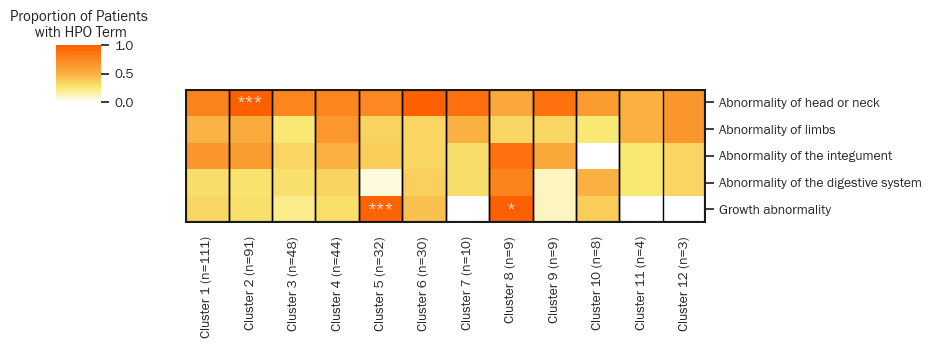

In [28]:
# Filter for top-level HPO terms list
topLevelPhenotypesList = ("Abnormality of head or neck",  "Abnormality of limbs", "Abnormality of the integument", "Abnormality of the digestive system", "Growth abnormality")
clusterFreqPhenotypesFiltered  = clusterFreqPhenotypes[clusterFreqPhenotypes.index.isin(topLevelPhenotypesList)]
clusterFreqPhenotypesFiltered.index = (pd.Categorical(clusterFreqPhenotypesFiltered.index, categories=topLevelPhenotypesList, ordered=True))
clusterFreqPhenotypesFiltered = clusterFreqPhenotypesFiltered.sort_index()

clusterFreqPvalFiltered  = clusterFreqPval[clusterFreqPval.index.isin(topLevelPhenotypesList)]
clusterFreqPvalFiltered.index = pd.Categorical(clusterFreqPvalFiltered.index, categories=topLevelPhenotypesList, ordered=True)
clusterFreqPvalFiltered = clusterFreqPvalFiltered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)

sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusterFreqPhenotypesFiltered, cmap=cmap, method="ward", annot=clusterFreqPvalFiltered, figsize=(9, 3.15), 
                         row_cluster=False, col_cluster=False, fmt="", cbar_kws={'ticks':[0, 0.50, 1], 'orientation':'vertical'})
heatmap.ax_cbar.set_title('Proportion of Patients\n with HPO Term')

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 5, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

plt.savefig('./Figures/clusterHeatmapTopLevel.png', dpi=600)
plt.show()

- Visualise key differences between the 12 clusters

['Neurodevelopmental abnormality', 'Neurological speech impairment']
['Abnormality of the face', 'Abnormal nasal morphology']
['Behavioral abnormality', 'Autistic behavior']
['Abnormal eye physiology', 'Abnormality of the eye']
['Abnormality of body height', 'Growth abnormality']
['Abnormal skull morphology', 'Abnormality of skull size']
['Abnormal muscle tone', 'Abnormal muscle tone']
['Constipation', 'Postnatal growth retardation']
['Abnormal cardiac ventricle morphology', 'Ventricular septal defect']
['Abnormality of male external genitalia', 'Abnormal external genitalia']
['Abnormal heart morphology', 'Abnormality of cardiovascular system morphology']
['Microphthalmia', 'Abnormal lens morphology']


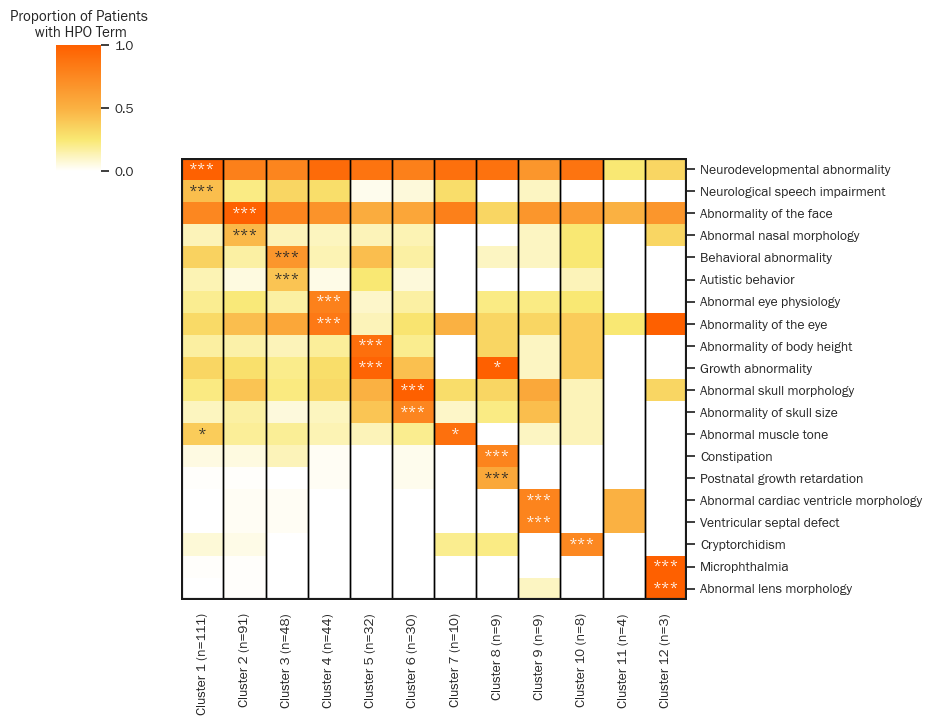

In [29]:
# Get all significant terms across all groups
allSigTerms = pd.DataFrame()
topPhenotypes = []
for i in range(1,13):

    # Get significant terms for each cluster
    clusterFreqSig = clusterFreq[clusterFreq['cluster_'+str(i)+'_adj_p_value'] < 0.05]
    clusterFreqSig = clusterFreqSig[clusterFreqSig['cluster_'+str(i)+'_OR'] > 1]
    allSigTerms = pd.concat([allSigTerms, clusterFreqSig], axis=0)

# Save to csv
allSigTerms = allSigTerms.reindex(sorted(allSigTerms.columns), axis=1)
allSigTerms.to_csv('./ClusteringPatientsOutput/clustersAllSigTerms.csv')

# Get top 2 HPO terms for each cluster by smallest p-value
topPhenotypes = []
for i in range(1,13):

    # Get 2 most significant terms for each cluster
    topCluster = allSigTerms.sort_values(by='cluster_'+str(i)+'_p_value', ascending=True)['hpo_term'].head(n=2)
    print(list(topCluster))
    topPhenotypes.append(topCluster)

# Flatten list
topPhenotypesFlatList = [item for sublist in topPhenotypes for item in sublist]

# Remove duplicated terms (significant in two clusters)
topPhenotypesFlatList.remove('Abnormal muscle tone') 

# Remove/replace parent terms that reflect a single child term
topPhenotypesFlatList.remove('Abnormal external genitalia')
topPhenotypesFlatList.remove('Abnormality of male external genitalia')
topPhenotypesFlatList.insert(17, 'Cryptorchidism')

# Remove terms that are not significant in relevant cluster
topPhenotypesFlatList.remove('Abnormal heart morphology') # Top term for cluster 11 but not significant
topPhenotypesFlatList.remove('Abnormality of cardiovascular system morphology')

# Filter using HPO terms list
clusterFreqPhenotypesFiltered  = clusterFreqPhenotypes[clusterFreqPhenotypes.index.isin(topPhenotypesFlatList)]
clusterFreqPhenotypesFiltered.index = pd.Categorical(clusterFreqPhenotypesFiltered.index, categories=topPhenotypesFlatList, ordered=True)
clusterFreqPhenotypesFiltered = clusterFreqPhenotypesFiltered.sort_index()

clusterFreqPvalFiltered  = clusterFreqPval[clusterFreqPval.index.isin(topPhenotypesFlatList)]
clusterFreqPvalFiltered.index = pd.Categorical(clusterFreqPvalFiltered.index, categories=topPhenotypesFlatList, ordered=True)
clusterFreqPvalFiltered = clusterFreqPvalFiltered.sort_index()

# Plot heatmap
cmap = LinearSegmentedColormap.from_list('custom', [(0, 'white'), (0.25, '#f9e873'), (0.5, '#fab142'), (1, '#fe6000')], N=256)
sns.set_style("white")
sns.set_theme(font_scale=0.9, font="Franklin Gothic Book")
heatmap = sns.clustermap(clusterFreqPhenotypesFiltered, cmap=cmap, method="ward", annot=clusterFreqPvalFiltered, figsize=(9, 7), 
                         row_cluster=False, col_cluster=False, fmt="", cbar_kws={'ticks':[0, 0.50, 1], 'orientation':'vertical'})
heatmap.ax_cbar.set_title('Proportion of Patients\n with HPO Term')

ax = heatmap.ax_heatmap
ax.add_patch(Rectangle((0,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((1,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((2,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((3,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((4,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((5,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((6,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((7,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((8,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((9,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((10,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((11,0 ), 1, 200, fill=False, edgecolor='black', lw=1))
ax.add_patch(Rectangle((12,0 ), 1, 200, fill=False, edgecolor='black', lw=1))

ax.axhline(y = 0, color='k',linewidth = 3) 
ax.axhline(y = 20, color = 'k', linewidth = 3) 
ax.axvline(x = 0, color = 'k', linewidth = 3) 
ax.axvline(x = 12, color = 'k', linewidth = 3)

plt.savefig('./Figures/clusterHeatmap.png', dpi=600)
plt.show()

In [31]:
# Crop images
from PIL import Image

im = Image.open("./Figures/clusterHeatmap.png".format())
im = im.crop((850, 600, 5500, 4800))
im.save("./Figures/clusterHeatmapCrop.png".format())

im = Image.open("./Figures/clusterHeatmapTopLevel.png".format())
im = im.crop((875, 280, 5950, 1150)) 
im.save("./Figures/clusterHeatmapTopLevelCrop.png".format())

# -------------------------------------------------------------------